<a href="https://colab.research.google.com/github/allenphos/ML-course-ua-/blob/main/Copy_of_HW_2_4_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B8_%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [2]:
!pip install opendatasets --upgrade --quiet

## Imports

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import os

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.plotting import plot_decision_regions

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [4]:
import opendatasets as od

# Download the dataset
od.download("https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2")

raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv', index_col=0)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anastasiaalyoshkina
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 29.6MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2


In [5]:
train_df, val_df = split_train_val(raw_df, target_col='Exited', test_size=0.2, random_state=42)

X_train, train_targets = separate_inputs_targets(train_df, input_cols=train_df.columns.tolist()[3:-1], target_col='Exited')
X_val, val_targets = separate_inputs_targets(val_df, input_cols=val_df.columns.tolist()[3:-1], target_col='Exited')

## Categorical features

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [6]:
cat_features = X_train.select_dtypes(include='object').columns
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')

In [7]:
X_train.dtypes

,0
Geography,category
Gender,category
Age,float64
Tenure,float64
Balance,float64
NumOfProducts,float64
HasCrCard,float64
IsActiveMember,float64
EstimatedSalary,float64


## XGBoostClassifier

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [8]:
from xgboost import XGBClassifier

In [9]:
! pip freeze | grep xgboost

xgboost==2.1.4


In [10]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf.fit(X_train, train_targets)

train_pred = xgb_clf.predict_proba(X_train)[:, 1]
val_pred = xgb_clf.predict_proba(X_val)[:, 1]
# Calculate AUROC for training and validation data
train_auroc = roc_auc_score(train_targets, train_pred)
val_auroc = roc_auc_score(val_targets, val_pred)

print(f"AUROC on training data: {train_auroc}")
print(f"AUROC on validation data: {val_auroc}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUROC on training data: 0.9328270874881045
AUROC on validation data: 0.9315210233898072


Ця модель має більшу точність та добре генералізує. У дерев було 0.915 на валідаційному набору даних.

## XGBoostClassifier with Hyperopt

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [11]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score

In [12]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        X_train,
        train_targets,
        eval_set=[(X_val, val_targets)],
        verbose=False)
    pred = clf.predict(X_val)
    auroc = roc_auc_score(val_targets, pred)

    return {'loss': -auroc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(X_train, train_targets)

# Predict on the training set for calculating train_auroc
train_pred = final_clf.predict_proba(X_train)[:, 1]
final_pred = final_clf.predict_proba(X_val)[:, 1]
# Calculate AUROC for training and validation data
train_auroc = roc_auc_score(train_targets, train_pred)
val_auroc = roc_auc_score(val_targets, final_pred)

print(f"AUROC on training data: {train_auroc}")
print(f"AUROC on validation data: {val_auroc}")

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|▌         | 1/20 [00:08<02:33,  8.08s/trial, best loss: -0.8169421771040538]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:29] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 2/20 [00:10<01:23,  4.64s/trial, best loss: -0.8169421771040538]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 3/20 [00:10<00:46,  2.75s/trial, best loss: -0.8169421771040538]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 5/20 [00:11<00:18,  1.26s/trial, best loss: -0.8169421771040538]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 30%|███       | 6/20 [00:11<00:12,  1.09trial/s, best loss: -0.8169421771040538]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 8/20 [00:12<00:06,  1.88trial/s, best loss: -0.8169421771040538]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 45%|████▌     | 9/20 [00:12<00:04,  2.35trial/s, best loss: -0.8169421771040538]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 10/20 [00:12<00:03,  2.70trial/s, best loss: -0.8169421771040538]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 11/20 [00:13<00:04,  2.24trial/s, best loss: -0.8169421771040538]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 12/20 [00:13<00:03,  2.37trial/s, best loss: -0.8169421771040538]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 14/20 [00:14<00:02,  2.99trial/s, best loss: -0.8267953906303587]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 75%|███████▌  | 15/20 [00:14<00:01,  3.11trial/s, best loss: -0.8267953906303587]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:14<00:00,  3.60trial/s, best loss: -0.8267953906303587]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 95%|█████████▌| 19/20 [00:15<00:00,  2.93trial/s, best loss: -0.8267953906303587]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

100%|██████████| 20/20 [00:15<00:00,  1.25trial/s, best loss: -0.8267953906303587]
Найкращі гіперпараметри:  {'colsample_bytree': 0.9197192859999643, 'gamma': 0.20397108650367413, 'learning_rate': 0.04911132288143887, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 300, 'reg_alpha': 0.5707766828112874, 'reg_lambda': 0.20471010839165993, 'subsample': 0.8891881434596929}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUROC on training data: 0.9654163022807091
AUROC on validation data: 0.9337375677344125


Найкращі гіперпараметри:  {'colsample_bytree': 0.8544616656571451, 'gamma': 0.2515689637913841, 'learning_rate': 0.09485987073407806, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 350, 'reg_alpha': 0.7997572689705342, 'reg_lambda': 0.1872851392960967, 'subsample': 0.8821319502815264}

AUROC on training data: 0.9654163022807091

AUROC on validation data: 0.9337375677344125

Точність моделі дуже покращилась на тренувальному набору, але з'явився overfit, так як точність на валідаційному наборі менша за точність на тренувальному.

## LightGBM

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [13]:
%%bash
sudo apt-get update
sudo apt-get install -y build-essential cmake git wget unzip
sudo apt-get install -y libboost-dev libboost-system-dev libboost-filesystem-dev
sudo apt-get install -y libboost-iostreams-dev libboost-program-options-dev libboost-regex-dev
sudo apt-get install -y libboost-thread-dev libboost-chrono-dev libboost-date-time-dev
sudo apt-get install -y libboost-atomic-dev libboost-serialization-dev
sudo apt-get install -y python3-pip

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.9ubuntu3).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
git is already the newest version (1:2.34.1-1ubuntu1.12).


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [14]:
%%bash
sudo apt-get install -y ocl-icd-libopencl1 clinfo
sudo apt-get install -y nvidia-opencl-dev opencl-headers

Reading package lists...
Building dependency tree...
Reading state information...
clinfo is already the newest version (3.0.21.02.21-1).
ocl-icd-libopencl1 is already the newest version (2.2.14-3).
ocl-icd-libopencl1 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
nvidia-opencl-dev is already the newest version (11.5.1-1ubuntu1).
The following NEW packages will be installed:
  opencl-headers
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 1,754 B of archives.
After this operation, 12.3 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 opencl-headers all 3.0~2022.01.04-1 [1,754 B]
Fetched 1,754 B in 0s (7,738 B/s)
Selecting previously unselected package opencl-headers.
(Reading database ... 125809 files and directories currently installed.)
Preparing to unpack .../opencl-headers_3.0~20

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [21]:
%%bash
git clone --recursive https://github.com/microsoft/LightGBM
cd LightGBM
mkdir build
cd build
cmake -DUSE_CUDAP=1 ..
make -j4

-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /content/LightGBM/build
[  2%] Built target lightgbm_capi_objs
[ 89%] Built target lightgbm_objs
[ 92%] Built target _lightgbm
[100%] Built target lightgbm


fatal: destination path 'LightGBM' already exists and is not an empty directory.
mkdir: cannot create directory ‘build’: File exists


In [26]:
import lightgbm as lgb
print(lgb.__version__)  # Should print 4.x.x or later

# Check if GPU is enabled
print("GPU Available:", lgb.__dict__.get('GPU_SUPPORTED', False))


4.5.0
GPU Available: False


Categorical feature indexes for LightGBM

In [18]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]

In [63]:
for col in cat_features:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")

In [28]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf.fit(
    X_train, train_targets, eval_set=[(X_val, val_targets)])

train_pred = lgb_clf.predict_proba(X_train)[:, 1]
final_pred = lgb_clf.predict_proba(X_val)[:, 1]

# Calculate AUROC for training and validation data
train_auroc = roc_auc_score(train_targets, train_pred)
val_auroc = roc_auc_score(val_targets, final_pred)

print(f"AUROC on training data: {train_auroc}")
print(f"AUROC on validation data: {val_auroc}")

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=0,1, categorical_column=0,1 will be ignored. Current value: categorical_feature=0,1
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 9
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

AUROC on training data: 0.9378816412714719

AUROC on validation data: 0.9362415117634955

Точність моделі стала трохи краща за XGBClassifier. Та більше немає перенавчання, модель непогано генералізує.

## LightGBM with Hyperopt

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [30]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(
        X_train, train_targets,
        eval_set=[(X_val, val_targets)],
        eval_metric="auc"
    )
    pred = clf.predict(X_val)
    auroc = roc_auc_score(val_targets, pred)

    return {'loss': -auroc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_lgb_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_lgb_clf.fit(
    X_train, train_targets,
    eval_set=[(X_val, val_targets)],
    eval_metric="auc"
)

# Predict on the training set for calculating train_auroc
train_pred = final_lgb_clf.predict_proba(X_train)[:, 1]
final_pred = final_lgb_clf.predict_proba(X_val)[:, 1]

# Calculate AUROC for training and validation data
train_auroc = roc_auc_score(train_targets, train_pred)
val_auroc = roc_auc_score(val_targets, final_pred)


print(f"AUROC on training data: {train_auroc}")
print(f"AUROC on validation data: {val_auroc}")

[LightGBM] [Warning] categorical_feature is set with cat_feature=0,1, categorical_column=0,1 will be ignored. Current value: categorical_feature=0,1
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

AUROC on training data: 0.9661815984791503

AUROC on validation data: 0.9329220111118732

AUROC на тренувальних даних 0.966, на валідаційному 0.932, що показує невеличке перенавчання, але точність, в порівнянні з XGBoostClassifier, трохи виросла, було 0.931. Тож поки це найкраща модель.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [31]:
# Навчання фінальної моделі з найкращими гіперпараметрами
model = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

model.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=0,1, categorical_column=0,1 will be ignored. Current value: categorical_feature=0,1
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 9
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

LGBMClassifier(cat_feature=[0, 1], colsample_bytree=0.6107157500552444,
               learning_rate=0.06773887181991506, max_depth=9,
               min_child_weight=7, min_split_gain=0.09297732066185448,
               missing=nan, n_estimators=250, num_leaves=39,
               reg_alpha=0.7095171249185069, reg_lambda=0.7684749636199297,
               subsample=0.7776749341201101)

In [35]:
# Load the test data
test_raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/test.csv')

# Select the same features used for training
test_raw_df = test_raw_df[train_df.columns.tolist()[3:-1]]  # Select the same columns as X_train


cat_features = test_raw_df.select_dtypes(include='object').columns
test_raw_df[cat_features] = test_raw_df[cat_features].astype('category')

# Make predictions using the trained model
predictions = model.predict_proba(test_raw_df)[:, 1]

# Assign predictions to the 'Exited' column
test_raw_df['Exited'] = predictions

# Create the submission file
sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv')
sample_submission = sample_submission.reset_index(drop=True)
test_raw_df = test_raw_df.reset_index(drop=True)
sample_submission['Exited'] = test_raw_df['Exited']

sample_submission.to_csv('submission_LightGBM.csv', index=False)

sample_submission['Exited']

[LightGBM] [Warning] Unknown parameter: missing


,Exited
0,0.042977
1,0.011988
2,0.033198
3,0.575047
4,0.020551
...,...
9995,0.011905
9996,0.020879
9997,0.008989
9998,0.051824


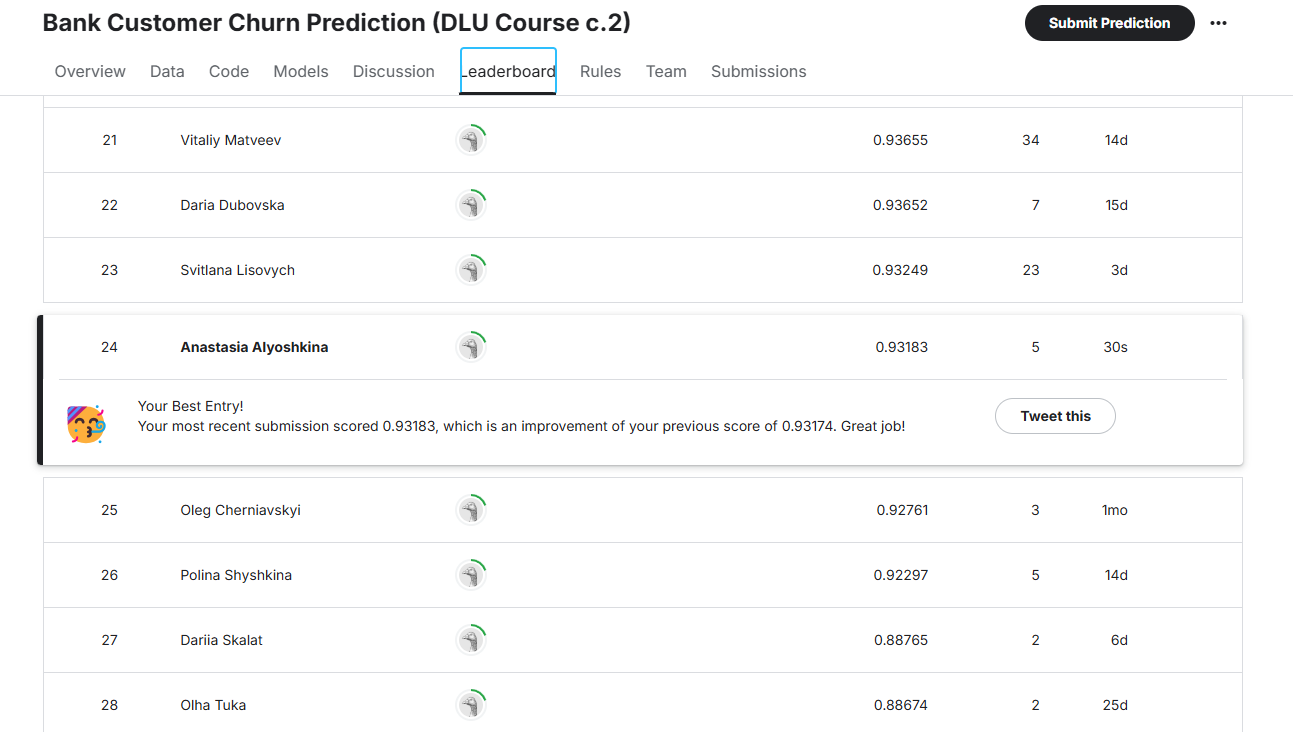